# User Churn Prediction

In this project, we use supervised learning models to identify customers who are likely to stop using service in the future. Furthermore, we will analyze top factors that influence user retention.

CAUTION--------------------------------------------------------CAUTION

CAUTION--------------------------------------------------------CAUTION

CAUTION--------------------------------------------------------CAUTION

CAUTION--------------------------------------------------------CAUTION

CAUTION--------------------------------------------------------CAUTION


my version of this project require the imblearn package

Package can be installed with Anaconda

conda install -c glemaitre imbalanced-learn

or PIP

pip install -U imbalanced-learn

<ul>
<li>[Part 1: EDA and Preprocessing](#Part-1:-EDA-and-Preprocessing)
<li>[Part 2: Model Training](#Part-2:-Model-Training)
<li>[Part 3: Grid Search and Model Evaluation](#Part-3:-Grid-Search-and-Model-Evaluation)
<li>[Part 4: Feature Importance Analysis](#Part-4:-Feature-Importance-Analysis)
<li>[Part 5: Back to Unbalance Dataset](#Part-5:-Back-to-Unbalance-Dataset)
</ul>

## EDA and Preprocessing

In [45]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

churn_df = pd.read_csv('data/churn.all')

In [46]:
print 'Number of Samples: ', churn_df.shape[0]
print 'Number of Columns: ', churn_df.shape[1]
churn_df.head()

Number of Samples:  5000
Number of Columns:  21


,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


## Numerical Features.

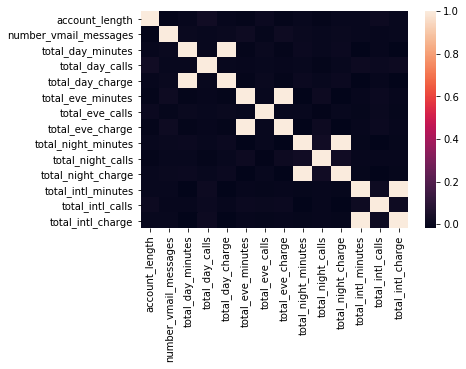

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

corr = churn_df[["account_length", "number_vmail_messages", "total_day_minutes",
                    "total_day_calls", "total_day_charge", "total_eve_minutes",
                    "total_eve_calls", "total_eve_charge", "total_night_minutes",
                    "total_night_calls","total_night_charge", "total_intl_minutes", 
                     "total_intl_calls","total_intl_charge"]].corr()

sb.heatmap(corr)

In [48]:
from scipy.stats import pearsonr

day_cor = pearsonr(churn_df['total_day_minutes'], churn_df['total_day_charge'])[0]
eve_cor = pearsonr(churn_df['total_eve_minutes'], churn_df['total_eve_charge'])[0]
night_cor = pearsonr(churn_df['total_night_minutes'], churn_df['total_night_charge'])[0]
intl_cor = pearsonr(churn_df['total_intl_minutes'], churn_df['total_intl_charge'])[0]

print 'Total day minutes vs charge: ', day_cor
print 'Total eve minutes vs charge: ', eve_cor
print 'Total night minutes vs charge: ', night_cor
print 'Total intl minutes vs charge: ', intl_cor

Total day minutes vs charge:  0.999999950983
Total eve minutes vs charge:  0.999999774863
Total night minutes vs charge:  0.999999207187
Total intl minutes vs charge:  0.999992657021


From the corr plot and the pearson coeffcients, we can observe that "minutes" columns has high correlation with "charge" columns. This make sence since the number of charge is based on the length of service used. Thus, we may drop all the "minutes" columns or all the "charge" columns since keeping both of them will not provide extra information. 

In [49]:
churn_df.drop(['total_day_charge','total_eve_charge','total_intl_charge','total_night_charge'], axis=1, inplace=True)
churn_df.head()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,197.4,99,244.7,91,10.0,3,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,195.5,103,254.4,103,13.7,3,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,121.2,110,162.6,104,12.2,5,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,61.9,88,196.9,89,6.6,7,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,148.3,122,186.9,121,10.1,3,3,False.


## Catogorical Features

#### Homework 1: Can you add catogorical features, e.g. state, into your feature matrix?

Now, I will focus on the categorical features. I will first observe the "state" and the "area_code" columns. I will first convert yes/no and True/False into 1/0.

In [50]:
churn_df['voice_mail_plan'] = churn_df['voice_mail_plan'].map(lambda x: x.strip())
churn_df['intl_plan'] = churn_df['intl_plan'].map(lambda x: x.strip())
churn_df['churned'] = churn_df['churned'].map(lambda x: x.strip())

churn_df['churned'].replace(to_replace='True.',value=1,inplace=True)
churn_df['churned'].replace(to_replace='False.',value=0,inplace=True)
churn_df['voice_mail_plan'].replace(to_replace='no',value=0,inplace=True)
churn_df['voice_mail_plan'].replace(to_replace='yes',value=1,inplace=True)
churn_df['intl_plan'].replace(to_replace='no',value=0,inplace=True)
churn_df['intl_plan'].replace(to_replace='yes',value=1,inplace=True)

In [51]:
print churn_df['area_code'].value_counts()
print churn_df['state'].value_counts()

415    2495
408    1259
510    1246
Name: area_code, dtype: int64
WV    158
MN    125
AL    124
ID    119
VA    118
OH    116
TX    116
WY    115
NY    114
OR    114
NJ    112
UT    112
WI    106
ME    103
MA    103
MI    103
MD    102
VT    101
KY     99
KS     99
CT     99
MT     99
MS     99
RI     99
WA     98
IN     98
CO     96
NH     95
DE     94
MO     93
AR     92
NM     91
SC     91
NC     91
FL     90
NV     90
OK     90
AZ     89
TN     89
IL     88
DC     88
NE     88
ND     88
HI     86
SD     85
GA     83
LA     82
PA     77
AK     72
IA     69
CA     52
Name: state, dtype: int64


CONFUSION: There are only three distinct area codes in this dataset which are 415, 408, and 510. Based on my google result, 415 is corresponding to San Francisco, California. 408 is corresponding to San Jose. 510 is corresponding to Oakland area. All of these area are in CA. So why there are 51 states contain in the dataset? Due to this confusion, I will drop the area_code column, and trust the state column.

In [52]:
churn_df.drop(['area_code'],axis=1,inplace=True)
churn_df.head()

,state,account_length,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,churned
0,KS,128,382-4657,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0
1,OH,107,371-7191,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0
2,NJ,137,358-1921,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0
3,OH,84,375-9999,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0
4,OK,75,330-6626,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0


Now, let's look at the state column. As observed before, the state column contain 51 distinct states, and all samples are nearly uniformly distributed in these states. One way to embed the state column could be one hot encoding. However, this approach would result 50 more features, and there is a chance of overfitting. I will embed state feature as probability of the user churned in the state. There are two benefit of this embedding. First, I'm not increasing the dimension of the dataset. Second, it makes sense intuitively. If many users in a state churned the service, there is a greater chance for other user to churned the service in the same state.

In [53]:
distinct_state = churn_df['state'].value_counts()
state_map = {}
for each_state in list(distinct_state.index):
    num_of_true = churn_df[(churn_df['state']==each_state) & (churn_df['churned']==1)].shape[0]
    num_of_false = churn_df[(churn_df['state']==each_state) & (churn_df['churned']==0)].shape[0]
    state_map[each_state] = num_of_true/float(num_of_true+num_of_false)
    
for state_name, value in state_map.iteritems():
    churn_df['state'].replace(to_replace=state_name, value=value,inplace=True)
churn_df.head()

,state,account_length,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,churned
0,0.181818,128,382-4657,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0
1,0.129310,107,371-7191,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0
2,0.250000,137,358-1921,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0
3,0.129310,84,375-9999,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0
4,0.177778,75,330-6626,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0


I will drop the "phone_number" column, since I assume that the phone number was randomly assigned to each user.

In [54]:
churn_df.drop(['phone_number'], axis=1, inplace=True)
churn_df.head()

,state,account_length,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,churned
0,0.181818,128,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0
1,0.129310,107,0,1,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0
2,0.250000,137,0,0,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0
3,0.129310,84,1,0,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0
4,0.177778,75,1,0,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0


Let's look at the remaining two features which are 'intl_plan' and 'voice_mail_plan'

In [55]:
print 'Correlation between voice_mail_plan and chruned is :',pearsonr(churn_df['voice_mail_plan'], churn_df['churned'])[0]
print 'Correlation between intl_plan and chruned is :',pearsonr(churn_df['intl_plan'], churn_df['churned'])[0]

Correlation between voice_mail_plan and chruned is : -0.110698256336
Correlation between intl_plan and chruned is : 0.259122645464


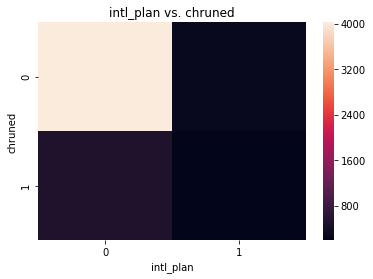

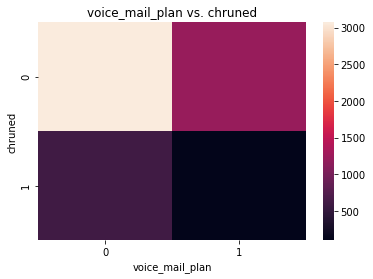

In [56]:
from sklearn.metrics import confusion_matrix
con_matrix_intl = confusion_matrix(churn_df['churned'],churn_df['intl_plan'])
ax1 = plt.axes()
sb.heatmap(con_matrix_intl, ax = ax1)
ax1.set_title('intl_plan vs. chruned')
ax1.set_xlabel('intl_plan')
ax1.set_ylabel('chruned')
plt.show()
con_matrix_voice = confusion_matrix(churn_df['churned'],churn_df['voice_mail_plan'])
ax2 = plt.axes()
sb.heatmap(con_matrix_voice, ax = ax2)
ax2.set_title('voice_mail_plan vs. chruned')
ax2.set_xlabel('voice_mail_plan')
ax2.set_ylabel('chruned')
plt.show()

Based on the Pearson Coefficient and the confusion matrix plot, both of these features have low correlation with the 'churned' column. I will keep these two features as 1/0 embedding for my classifier.

Now I finished my feature exploration.

Is there any missing value in the dataset?

In [57]:
print "Number of sample before dropna: ",churn_df.shape[0]
churn_df.dropna(inplace = True)
print "Number of sample after dropna: ",churn_df.shape[0]

Number of sample before dropna:  5000
Number of sample after dropna:  5000


There is no row with missing value. Let's check if the dataset is balanced.

In [58]:
churn_df['churned'].value_counts()

0    4293
1     707
Name: churned, dtype: int64

I will balance the dataset using over-sampling, since this is a small dataset. One way to do the over-sampling is to put copys of the sample from the minority class into the dataset. This approach could cause overfitting. I will use SMOTE algorithm to perform the over-sampling on the training samples. SMOTE algorithm will generate samples based on KNN, and the sample generated will be more generalize. Moreover, it is important to use SMOTE only for training samples, not for cross validation samples. The synthetic samples should never be used to validate the model.

In [59]:
print 'Number of samples :',churn_df.shape[0]
print 'Number of features :',churn_df.shape[1]-1

Number of samples : 5000
Number of features : 14


# Part 2: Model Training

In [60]:
y = np.asarray(churn_df['churned'])
X = np.asarray(churn_df.drop(['churned'],axis=1))

In [61]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

print "Feature space holds %d observations and %d features" % X.shape
print "Unique target labels:", np.unique(y)

Feature space holds 5000 observations and 14 features
Unique target labels: [0 1]


In [62]:
from sklearn.cross_validation import KFold
from imblearn.over_sampling import SMOTE

#This program does 5-fold. It saves the result at each time as different parts of y_pred. 
#In the end, it returns the y_pred as the result of all the five 5-fold.
def run_cv(X,y,clf_class,enable_SMOTE=False,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    clf = clf_class(**kwargs)
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        if enable_SMOTE:
            #Apply SMOTE to over-sample the training set in order to have a balanced training set
            sm=SMOTE(random_state=42)
            X_res, y_res = sm.fit_sample(X_train, y_train)

            #The SMOTE function in imblearn API only allows numerical input, but I embeded three
            #categorical features into the dataset which are 'state', 'intl_plan', and 'voice_mail_plan'
            #The 'state' feature was converted into a probability, so it is a numerical now.
            #the 'intl_plan' and the 'voice_mail_plan' should be rounded after SMOTE
            X_res[:,1] = np.round(X_res[:,1]) #round the 'intl_plan'
            X_res[:,2] = np.round(X_res[:,2]) #round the 'voice_mail_plan'
            X_train, y_train = X_res, y_res
            
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

def accuracy(y_true,y_pred):
    return np.mean(y_true == y_pred) # NumPy interpretes True and False as 1. and 0.

LR_CV_result_SMOTE_on = run_cv(X,y,LogisticRegression,enable_SMOTE=True)
RF_CV_result_SMOTE_on = run_cv(X,y,RandomForestClassifier,enable_SMOTE=True)
KNN_CV_result_SMOTE_on = run_cv(X,y,KNeighborsClassifier,enable_SMOTE=True) #Default: n_neighbors=5

print "Result with SMOTE enable"
print "Logistic Regression (L2 is default): " + str(accuracy(y, LR_CV_result_SMOTE_on))
print "Random forest: " + str(accuracy(y, RF_CV_result_SMOTE_on))
print "K-nearest-neighbors: " + str(accuracy(y, KNN_CV_result_SMOTE_on))

Result with SMOTE enable
Logistic Regression (L2 is default): 0.8056
Random forest: 0.9324
K-nearest-neighbors: 0.8128


In [64]:
LR_CV_result = run_cv(X,y,LogisticRegression)
RF_CV_result = run_cv(X,y,RandomForestClassifier)
KNN_CV_result = run_cv(X,y,KNeighborsClassifier) #Default: n_neighbors=5

print "Result with SMOTE disable"
print "Logistic Regression (L2 is default): " + str(accuracy(y, LR_CV_result))
print "Random forest: " + str(accuracy(y, RF_CV_result))
print "K-nearest-neighbors: " + str(accuracy(y, KNN_CV_result))

Result with SMOTE disable
Logistic Regression (L2 is default): 0.8672
Random forest: 0.933
K-nearest-neighbors: 0.892


The performance is getting worse when the SMOTE is enabled. However, I cannot conclude that over-sampling the training set is a bad approach at this point. First, all three model was using default hyper-pamater. I will fine-tune the hyper-parameter to further evalute the models and over-sampling approach. Second, since the dataset is unbalance, the performance should be evaluated with matrices other than accuracy.

#### Homework 2: Can you do prediction with SVM model?

First, let's apply Linear SVM. Then, I will test performance using kernal trick.

In [65]:
from sklearn.svm import LinearSVC


SVC_CV_result_SMOTE_on = run_cv(X,y,LinearSVC,enable_SMOTE=True)
print "Result with SMOTE enable : " + str(accuracy(y, SVC_CV_result_SMOTE_on))
SVC_CV_result = run_cv(X,y,LinearSVC)
print "Result with SMOTE disable : " + str(accuracy(y, SVC_CV_result))

Result with SMOTE enable : 0.8022
Result with SMOTE disable : 0.8676


In [66]:
#Using SVM with rbf kernal
from sklearn.svm import SVC

SVC_kernal_result_SMOTE_on = run_cv(X,y,SVC,enable_SMOTE = True)
print "Result with SMOTE enable : " + str(accuracy(y, SVC_kernal_result_SMOTE_on))
SVC_kernal_result = run_cv(X,y,SVC,enable_SMOTE = False)
print "Result with SMOTE disable : " + str(accuracy(y, SVC_kernal_result))


Result with SMOTE enable : 0.9148
Result with SMOTE disable : 0.9234


# Part 3: Grid Search and Model Evaluation

First, let's select few classifier from all the classifier we used before.

In [67]:
print "Result with SMOTE enable"
print "Logistic Regression (L2 is default): " + str(accuracy(y, LR_CV_result_SMOTE_on))
print "Random forest: " + str(accuracy(y, RF_CV_result_SMOTE_on))
print "K-nearest-neighbors: " + str(accuracy(y, KNN_CV_result_SMOTE_on))
print "Linear SVM: " + str(accuracy(y, SVC_CV_result_SMOTE_on))
print "SVM with rbf kernal: " + str(accuracy(y, SVC_kernal_result_SMOTE_on))

Result with SMOTE enable
Logistic Regression (L2 is default): 0.8056
Random forest: 0.9324
K-nearest-neighbors: 0.8128
Linear SVM: 0.8022
SVM with rbf kernal: 0.9148


In [68]:
print "Result with SMOTE disable"
print "Logistic Regression (L2 is default): " + str(accuracy(y, LR_CV_result))
print "Random forest: " + str(accuracy(y, RF_CV_result))
print "K-nearest-neighbors: " + str(accuracy(y, KNN_CV_result))
print "Linear SVM : " + str(accuracy(y, SVC_CV_result))
print "SVM with rbf kernal : " + str(accuracy(y, SVC_kernal_result))

Result with SMOTE disable
Logistic Regression (L2 is default): 0.8672
Random forest: 0.933
K-nearest-neighbors: 0.892
Linear SVM : 0.8676
SVM with rbf kernal : 0.9234


I will use grid search to fine-tune the hyper-parameter for Random forest, K-nearest-neighbors, and SVM with rbf kernal, since they have the best performance from last section.

In [69]:
def print_grid_search_metrics(gs):
    print "Best score: %0.3f" % gs.best_score_
    print "Best parameters set:"
    best_parameters = gs.best_params_
    for param_name in sorted(best_parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

### Random Forest

In [70]:
#Random Forest
from sklearn.grid_search import GridSearchCV
RF_parameters = {
    'n_estimators':(10,30,50,100), 
    'max_depth':(1,2,5,8,10,12),
    'max_features':(0.2,0.3,0.5,0.8)
}
Random_Forest_Grid_LR = GridSearchCV(RandomForestClassifier(n_jobs=-1),RF_parameters, cv=5, verbose=1,n_jobs=-1)
Random_Forest_Grid_LR.fit(X, y)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   22.3s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': (10, 30, 50, 100), 'max_features': (0.2, 0.3, 0.5, 0.8), 'max_depth': (1, 2, 5, 8, 10, 12)},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [71]:
print_grid_search_metrics(Random_Forest_Grid_LR)

Best score: 0.957
Best parameters set:
	max_depth: 12
	max_features: 0.5
	n_estimators: 50


### K-Nearest-Neighbors

In [72]:
#K-Nearest-Neighbors
KNN_parameters = {
    'n_neighbors':(3,5,8,10,20,50,100),
    'p':(1,2)
}
KNN_Grid_LR = GridSearchCV(KNeighborsClassifier(n_jobs=-1),KNN_parameters, cv=5, verbose=1,n_jobs=-1)
KNN_Grid_LR.fit(X, y)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    2.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': (3, 5, 8, 10, 20, 50, 100), 'p': (1, 2)},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [73]:
print_grid_search_metrics(KNN_Grid_LR)

Best score: 0.890
Best parameters set:
	n_neighbors: 5
	p: 2


### SVC with rbf Kernal

In [74]:
#SVM with kernal
SVC_parameters = {
    'C':(1,10,100,1000,10000),
    'gamma':(0.1,1,10,100)
}
SVC_Grid_LR = GridSearchCV(SVC(),SVC_parameters, cv=5, verbose=1,n_jobs=-1)
SVC_Grid_LR.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': (1, 10, 100, 1000, 10000), 'gamma': (0.1, 1, 10, 100)},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [75]:
print_grid_search_metrics(SVC_Grid_LR)

Best score: 0.926
Best parameters set:
	C: 10
	gamma: 0.1


### Calculate Confusion Matrix (Precision, Recall, Accuracy)

In [76]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print classifier
    print "Accuracy is " + str(accuracy)
    print "Precision is " + str(precision)
    print "Recall is " + str(recall)

def draw_confusion_matrices(confusion_matricies,class_names):
    class_names = ['Not','Churn']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [77]:
y_RF = Random_Forest_Grid_LR.predict(X)
y_KNN = KNN_Grid_LR.predict(X)
y_SVC = SVC_Grid_LR.predict(X)

[0 1]
Random Forest
Accuracy is 0.983
Precision is 1.0
Recall is 0.879773691655


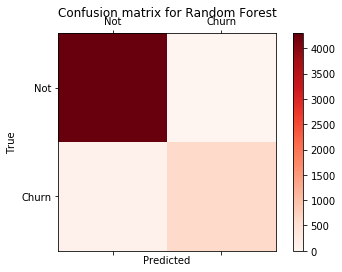

K-Nearest-Neighbors
Accuracy is 0.924
Precision is 0.922480620155
Recall is 0.50495049505


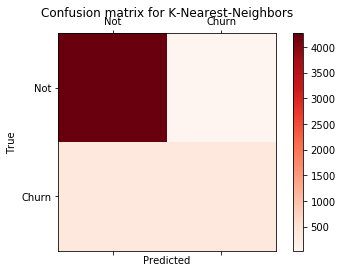

SVC with rbf kernal
Accuracy is 0.989
Precision is 0.996951219512
Recall is 0.925035360679


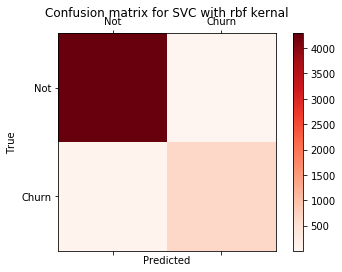

In [78]:
%matplotlib inline

y = np.array(y)
class_names = np.unique(y)
print class_names

confusion_matrices = [
    ("Random Forest", confusion_matrix(y,y_RF)),
    ("K-Nearest-Neighbors", confusion_matrix(y,y_KNN)),
    ("SVC with rbf kernal", confusion_matrix(y,y_SVC))
]

draw_confusion_matrices(confusion_matrices,class_names)

Both Random Forest and SVC with rbf kernal has good performance compare to K-Nearest-Neighbors. Let's dive into model interpolation for Random Forest and SVC. 

# Part 4: Feature Importance Analysis

## Random Forest

The random forest model api in sklearn has build in Feature importances method. If a feature is important, it will show up on the top level of many decision tree in the random forest model. In order to use the feature_importance method, I have to train a Random Forest model using the best hyper-parameter from GridSearch.

In [79]:
#run_cv modified:
#The reason I need to have a modified version of run_cv is that 
#I need a function which return the model itself instead of the y_pred

#This program does 5-fold. It saves the result at each time as different parts of y_pred. 
#In the end, it returns the y_pred as the result of all the five 5-fold.
def run_cv_modified(X,y,clf_class,enable_SMOTE=False,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    clf = clf_class(**kwargs)
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        if enable_SMOTE:
            #Apply SMOTE to over-sample the training set in order to have a balanced training set
            sm=SMOTE(random_state=42)
            X_res, y_res = sm.fit_sample(X_train, y_train)

            #The SMOTE function in imblearn API only allows numerical input, but I embeded three
            #categorical features into the dataset which are 'state', 'intl_plan', and 'voice_mail_plan'
            #The 'state' feature was converted into a probability, so it is a numerical now.
            #the 'intl_plan' and the 'voice_mail_plan' should be rounded after SMOTE
            X_res[:,1] = np.round(X_res[:,1]) #round the 'intl_plan'
            X_res[:,2] = np.round(X_res[:,2]) #round the 'voice_mail_plan'
            X_train, y_train = X_res, y_res
            
        clf.fit(X_train,y_train)
    return clf

### Build in Feature Importance mathod

In [80]:
best_parameter = Random_Forest_Grid_LR.best_params_
print best_parameter
for key,val in best_parameter.items():
        exec(key + '=val')
#The grid search for Random Forest returns the best value for 'max_features', 'n_estimators', and 'max_depth'
RF_classifier = run_cv_modified(X,
                                y,
                                RandomForestClassifier,
                                enable_SMOTE=False,
                                max_features=max_features,
                                n_estimators=n_estimators,
                                max_depth=max_depth)

y_pred_RF = RF_classifier.predict(X)
print 'Accuracy : ' ,accuracy(y, y_pred_RF)
print 'Precision : ',precision_score(y,y_pred_RF)
print 'Recall : ' ,recall_score(y,y_pred_RF)

{'max_features': 0.5, 'n_estimators': 50, 'max_depth': 12}
Accuracy :  0.978
Precision :  0.976076555024
Recall :  0.865629420085


In [81]:
importance = RF_classifier.feature_importances_
column_name = churn_df.drop('churned',axis=1).columns


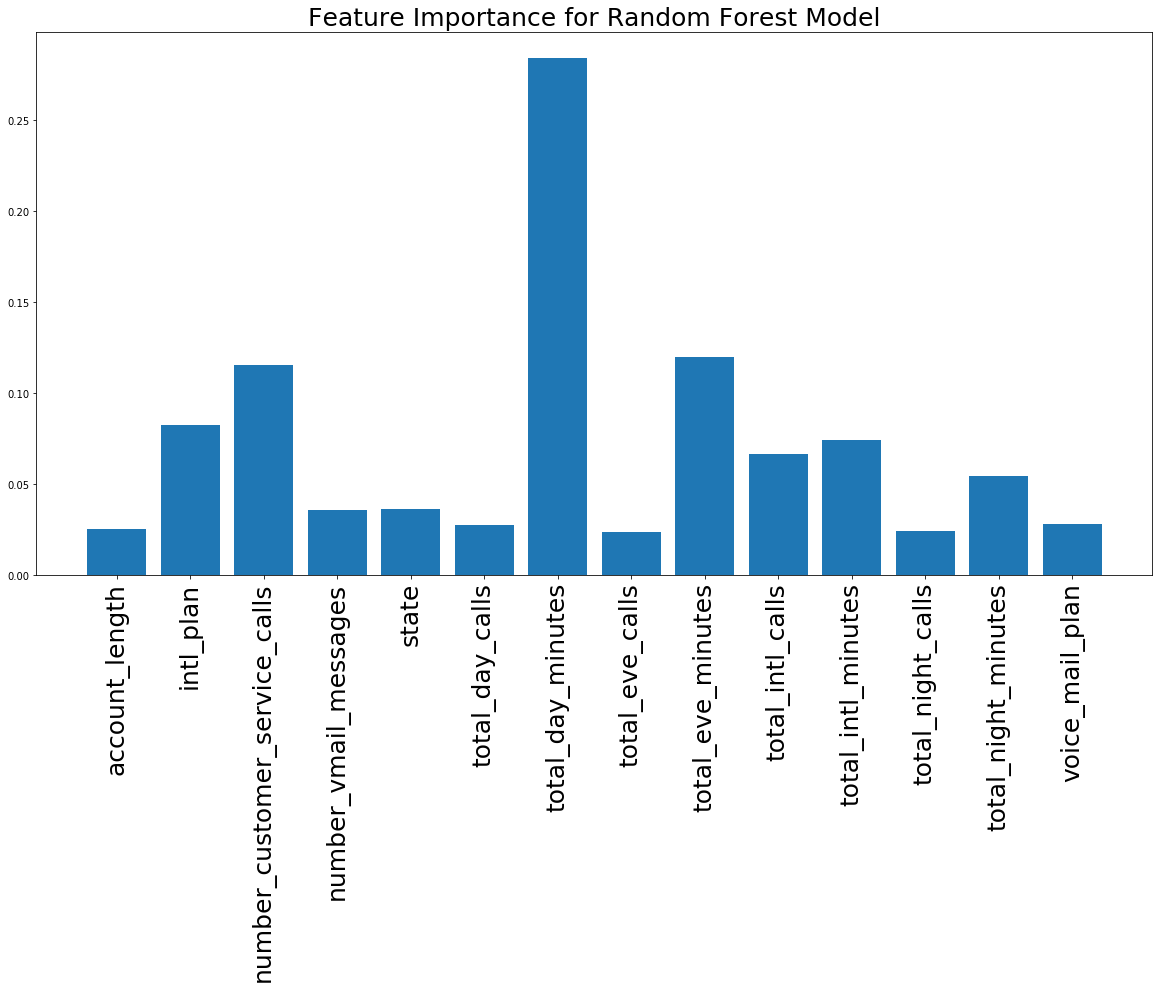

In [82]:
plt.figure(figsize=(20,10))
plt.title('Feature Importance for Random Forest Model',fontsize=25)
plt.bar(column_name,importance)
plt.xticks(rotation=90,fontsize=25)
plt.show()

From the bar chart above the top 3 most important features are 'total_day_minutes', 'number_customer_service_call', and 'total_eve_minutes'. We can verify this using another feature importance analysis approach.

### Analysis Feature Importance using Surrogate Model

The idea of surrogate model is using a simple, interpretable model to approximate the complex model. I will simply train a decision tree to fit on the output of the random forest. The purpose of this approach is that I'm trying to approximate the random forest, instead of the target function. Thus, the decision tree need to fit on the output of the random forest instead of the ground truth.

Surrogate Model: https://en.wikipedia.org/wiki/Surrogate_model

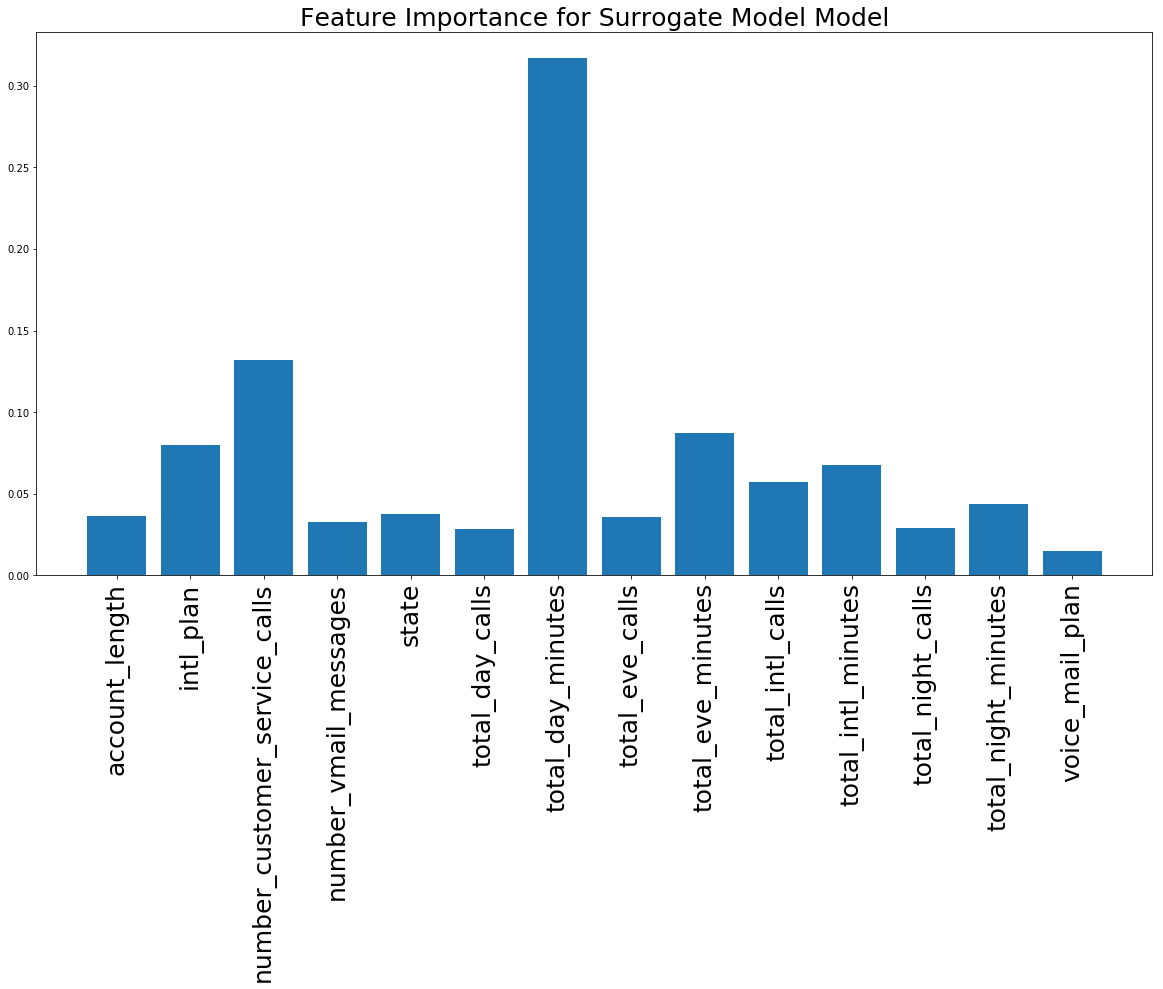

In [83]:
from sklearn.tree import DecisionTreeClassifier
Surrogate_Model = run_cv_modified(X,y_pred_RF,RandomForestClassifier,enable_SMOTE=False)
importance = Surrogate_Model.feature_importances_
plt.figure(figsize=(20,10))
plt.title('Feature Importance for Surrogate Model Model',fontsize=25)
plt.bar(column_name,importance)
plt.xticks(rotation=90,fontsize=25)
plt.show()

The surrogate model give the same result as the build in feature importance mathod. We can conclude that the top 3 most important features are 'total_day_minutes', 'number_customer_service_call', and 'total_eve_minutes'.

## SVC with rbf Kernal

In [84]:
best_parameter = SVC_Grid_LR.best_params_
print best_parameter
for key,val in best_parameter.items():
        exec(key + '=val')

#The grid search for SVC returns the best value for 'C' and 'gamma'
SVC_kernal_classifier = run_cv_modified(X,y,SVC,enable_SMOTE=False,C=C,gamma=gamma)
y_pred_SVC = SVC_kernal_classifier.predict(X)
print 'Accuracy : ' ,accuracy(y, y_pred_SVC)
print 'Precision : ',precision_score(y,y_pred_SVC)
print 'Recall : ' ,recall_score(y,y_pred_SVC)

{'C': 10, 'gamma': 0.1}
Accuracy :  0.9818
Precision :  0.976780185759
Recall :  0.892503536068


The feature importance measure for SVC with rbf kernal is not trivial. I will measure feature importance using feature ablation. The idea of feature ablation is remove each feature and retrain the model one at the time, and obeserve the performance reduction by removing each feature. However, the performance is not clearly defined in this project. Thus, I will define the performance as accuracy, since the SVC model is trying to maximize the accuracy.

0.9818
Accuracy Reduced by:  0.0058
Accuracy Reduced by:  0.0088
Accuracy Reduced by:  0.0174
Accuracy Reduced by:  0.0056
Accuracy Reduced by:  0.004
Accuracy Reduced by:  0.0458
Accuracy Reduced by:  0.0078
Accuracy Reduced by:  0.0174
Accuracy Reduced by:  0.005
Accuracy Reduced by:  0.0138
Accuracy Reduced by:  0.0072
Accuracy Reduced by:  0.0098
Accuracy Reduced by:  0.0094
Accuracy Reduced by:  0.0242


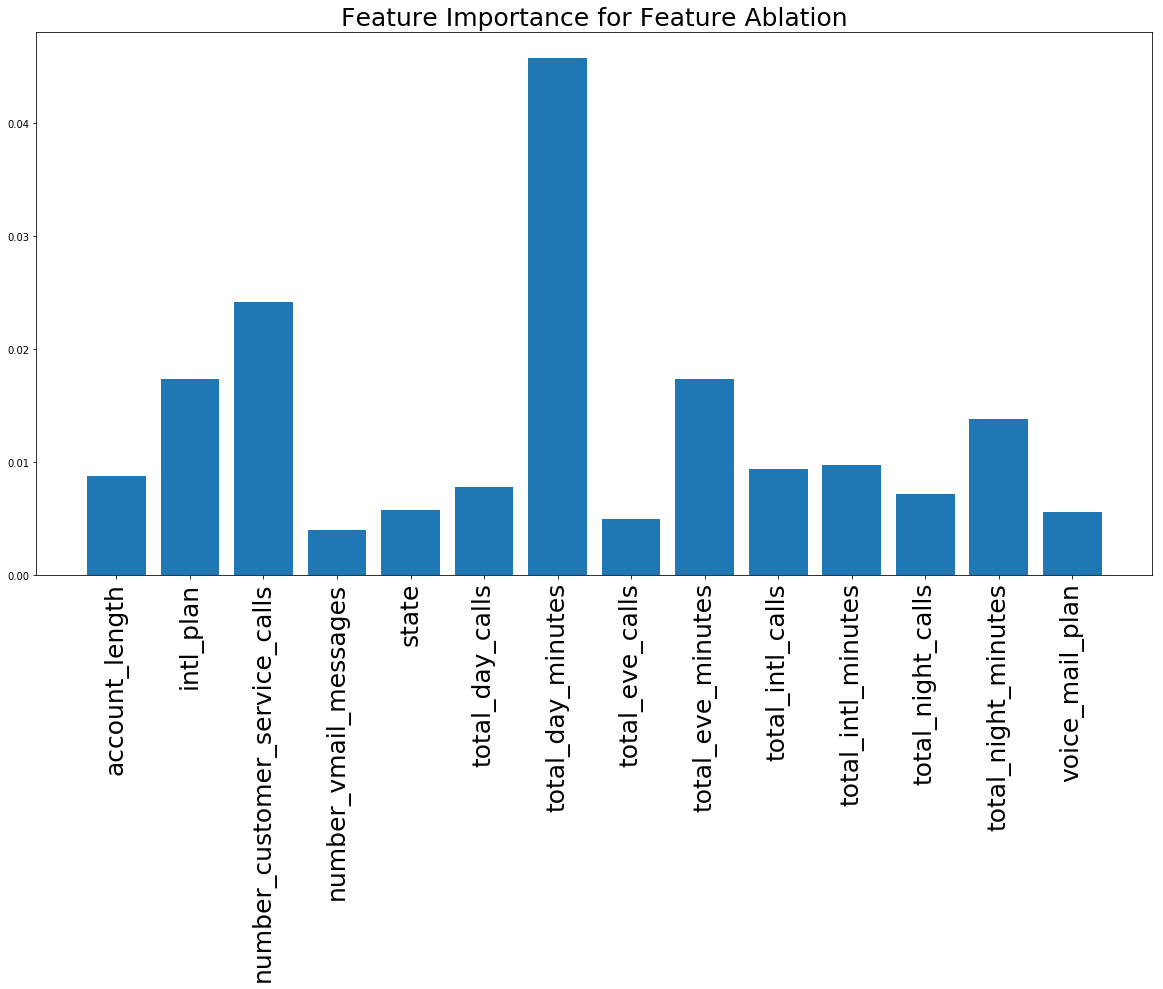

In [85]:
def feature_ablation(X,y,C,gamma,benchmark):
    acc = []
    for i in range(X.shape[1]):
        X_temp = np.delete(X, i, 1)
        SVC_temp = run_cv_modified(X_temp,y,SVC,enable_SMOTE=False,C=C,gamma=gamma)
        y_pred_SVC = SVC_temp.predict(X_temp)
        acc.append(benchmark - accuracy(y, y_pred_SVC))
        print 'Accuracy Reduced by: ' ,acc[-1]
    return acc
benchmark = accuracy(y, y_pred_SVC)
print benchmark
acc_reduced = feature_ablation(X,y,C,gamma,benchmark)
plt.figure(figsize=(20,10))
plt.title('Feature Importance for Feature Ablation',fontsize=25)
plt.bar(column_name,acc_reduced)
plt.xticks(rotation=90,fontsize=25)
plt.show()

The result from feature ablation using SVC with rbf kernal shows the same feature importance result as the Random Forest. Thus we can conlude the top 3 most important feature are 'total_day_minutes', 'number_customer_service_call', and 'total_eve_minutes'.

# Part 5: Back to Unbalance Dataset

I observed that the dataset is not balanced during Part 1. Moreover, as I tested in Part 2, using SMOTE over-sampling does not increase the performance. However, I cannot make conclusion about over-sampling since I haven't decide the hyper-parameter in Part 2. Now, I can test the over-sampling method with Random Forest and SVC with rbf Kernal. 

## Random Forest

In [86]:
best_parameter = Random_Forest_Grid_LR.best_params_
print best_parameter
for key,val in best_parameter.items():
        exec(key + '=val')
#The grid search for Random Forest returns the best value for 'max_features', 'n_estimators', and 'max_depth'
RF_classifier_SMOTE_off = run_cv_modified(X,
                                          y,
                                          RandomForestClassifier,
                                          enable_SMOTE=False,
                                          max_features=max_features,
                                          n_estimators=n_estimators,
                                          max_depth=max_depth)

RF_classifier_SMOTE_on = run_cv_modified(X,
                                          y,
                                          RandomForestClassifier,
                                          enable_SMOTE=True,
                                          max_features=max_features,
                                          n_estimators=n_estimators,
                                          max_depth=max_depth)

y_RF_SMOTE_off = RF_classifier_SMOTE_off.predict(X)
y_RF_SMOTE_on = RF_classifier_SMOTE_on.predict(X)
print 'Without Over-sampling'
print 'Accuracy : ' ,accuracy(y, y_RF_SMOTE_off)
print 'Precision : ',precision_score(y,y_RF_SMOTE_off)
print 'Recall : ' ,recall_score(y,y_RF_SMOTE_off)

print 'With Over-sampling'
print 'Accuracy : ' ,accuracy(y, y_RF_SMOTE_on)
print 'Precision : ',precision_score(y,y_RF_SMOTE_on)
print 'Recall : ' ,recall_score(y,y_RF_SMOTE_on)

{'max_features': 0.5, 'n_estimators': 50, 'max_depth': 12}
Without Over-sampling
Accuracy :  0.9802
Precision :  0.988745980707
Recall :  0.869872701556
With Over-sampling
Accuracy :  0.9826
Precision :  0.964071856287
Recall :  0.910891089109


## SVC with rbf Kernal

By applying the over-sampling, the recall is imporved. The accuracy and the precision is reletively the same.

In [87]:
best_parameter = SVC_Grid_LR.best_params_
print best_parameter
for key,val in best_parameter.items():
        exec(key + '=val')

#The grid search for SVC returns the best value for 'C' and 'gamma'
SVC_kernal_SMOTE_off = run_cv_modified(X,y,SVC,enable_SMOTE=False,C=C,gamma=gamma)
SVC_kernal_SMOTE_on = run_cv_modified(X,y,SVC,enable_SMOTE=True,C=C,gamma=gamma)

y_SVC_SMOTE_off = SVC_kernal_SMOTE_off.predict(X)
y_SVC_SMOTE_on = SVC_kernal_SMOTE_on.predict(X)

print 'Without Over-sampling'
print 'Accuracy : ' ,accuracy(y, y_SVC_SMOTE_off)
print 'Precision : ',precision_score(y,y_SVC_SMOTE_off)
print 'Recall : ' ,recall_score(y,y_SVC_SMOTE_off)

print 'With Over-sampling'
print 'Accuracy : ' ,accuracy(y, y_SVC_SMOTE_on)
print 'Precision : ',precision_score(y,y_SVC_SMOTE_on)
print 'Recall : ' ,recall_score(y,y_SVC_SMOTE_on)

{'C': 10, 'gamma': 0.1}
Without Over-sampling
Accuracy :  0.9778
Precision :  0.965625
Recall :  0.874115983027
With Over-sampling
Accuracy :  0.9756
Precision :  0.911392405063
Recall :  0.916548797737


In SVC with rbf model, the accuracy is reletively the same, but the recall is imporved and the percision is droped.

## Summary of Over-sampling

When applying over-sampling, the accuracy is reletively the same, but it improves the recall and drop the percision for both model. The over-sampling approach will increase the number of positive sample in the training set. Thus, the model will give more weighting to positive sample. The model will reduce the false negative and increase false positive due to this weighting change. Thus, it improves the recall and drop the percision.